In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import numpy as np
import glob
mpl.style.use('seaborn-talk')


In [28]:
# base_dir = '.'
# base_dir = './May-5-Take2'
# base_dir = './May12SynradExport'
# base_dir = './May12SynradExport-Take2'


base_dir = './Corrected-Beam-Parameter/tails only all magnets'
# base_dir = './Corrected-Beam-Parameter/Full beam and magnets'

In [29]:
df_flux = pd.read_excel(os.path.join(base_dir, 'Flux per facet.xlsx')  )

df_flux.set_index('Facet', inplace=True)

df_flux

,Hits,Flux (on facet),Power (on facet),Absorbed (on facet)
Facet,,,,
1,1344,26800000000,8.430000e-08,226
2,520,13700000000,4.510000e-08,116
3,193,3910000000,1.260000e-08,33
4,9,237000000,7.400000e-10,2
5,4,0,0.000000e+00,0
...,...,...,...,...
18983,2920041,361000000000000,1.160000e-02,0
18984,24956658,3450000000000000,1.830000e+00,0
18985,24955005,3450000000000000,1.830000e+00,0


In [30]:
# df_flux.loc[ 18985 , 'Flux (on facet)' ]

In [31]:
df_facets = pd.DataFrame()

In [32]:
filenames = glob.glob(os.path.join(base_dir, "./*.csv"))
print(len(filenames))
dfs = []

df_facets

cnt = 0;
for filename in filenames:
    cnt = cnt +1
    
    filename_base = os.path.basename(filename)
    try:
        facet_id = int(filename_base.split('.')[0]);
    except :
        print(f'Skip {filename_base}')
        continue;
        
    flux = df_flux.loc[ facet_id , 'Flux (on facet)' ]
    
    
    df = pd.read_csv(filename)
    scale = flux / df['Flux_[photon/s]'].sum();
    df['Flux_Normalized'] = df.apply(lambda x: x['Flux_[photon/s]'] * scale , axis =1)
    
    phi_average = np.arctan2(df['Pos_Y_[cm]'].mean(),df['Pos_X_[cm]'].mean())
    
    print(f'{cnt}: facet {facet_id} | <phi> = {phi_average} ->{filename} @ {flux:.2e} photon/s, scale = {scale}')
    
    df_facets = df_facets.append(
        {'Facet':facet_id, 
         'Flux': flux, 
#          'Power': df_flux.loc[ facet_id , 'Power (on facet)'],
         'Phi':phi_average}, ignore_index=True)
    
    dfs.append(df)
    

big_frame = pd.concat(dfs, ignore_index=True, sort=False)

9
1: facet 18964 | <phi> = 0.42341897865197303 ->./Corrected-Beam-Parameter/tails only all magnets/./18964.csv @ 2.79e+14 photon/s, scale = 0.00045692268399746025
2: facet 18965 | <phi> = 0.25720475525178005 ->./Corrected-Beam-Parameter/tails only all magnets/./18965.csv @ 6.55e+14 photon/s, scale = 0.0010613380846401525
3: facet 18966 | <phi> = 0.04681954121324842 ->./Corrected-Beam-Parameter/tails only all magnets/./18966.csv @ 1.68e+15 photon/s, scale = 0.001968592870077625
4: facet 18967 | <phi> = -0.046957524513656465 ->./Corrected-Beam-Parameter/tails only all magnets/./18967.csv @ 1.67e+15 photon/s, scale = 0.0019576451481331794
5: facet 18968 | <phi> = -0.25736987028999525 ->./Corrected-Beam-Parameter/tails only all magnets/./18968.csv @ 6.55e+14 photon/s, scale = 0.001060970062674526
6: facet 18983 | <phi> = -2.8977574710085383 ->./Corrected-Beam-Parameter/tails only all magnets/./18983.csv @ 3.61e+14 photon/s, scale = 0.0005766837356498543
7: facet 18984 | <phi> = -3.09024403

In [33]:

df_facets.set_index('Facet', inplace=True)
df_facets.to_csv(os.path.join(base_dir, 'Facet_CheckAll.csv'))
df_facets

,Flux,Phi
Facet,,
18964.0,2.790000e+14,0.423419
18965.0,6.550000e+14,0.257205
18966.0,1.680000e+15,0.046820
18967.0,1.670000e+15,-0.046958
18968.0,6.550000e+14,-0.257370
18983.0,3.610000e+14,-2.897757
18984.0,3.450000e+15,-3.090244
18985.0,3.450000e+15,-3.090540
18986.0,3.600000e+14,2.897706


In [34]:
Phi = big_frame.apply(lambda x : np.arctan2(x['Pos_Y_[cm]'], x['Pos_X_[cm]']), axis=1)

Text(0, 0.5, 'Sum[Virtual photon]/arc Virtual photon/bin')

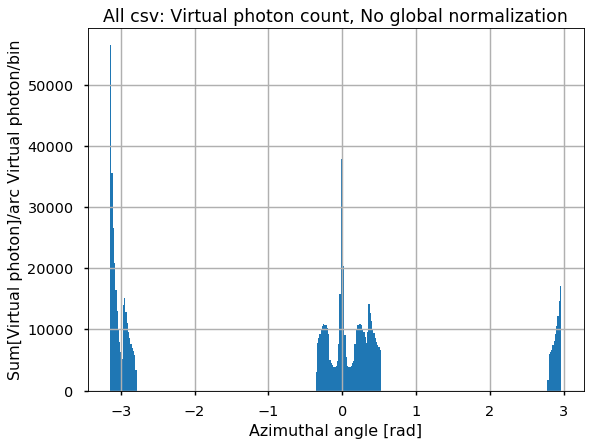

In [35]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
Phi.hist(bins=360)
plt.title('All csv: Virtual photon count, No global normalization')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Sum[Virtual photon]/arc Virtual photon/bin")

Text(0, 0.5, 'Sum[Flux]/arc photon/s/rad')

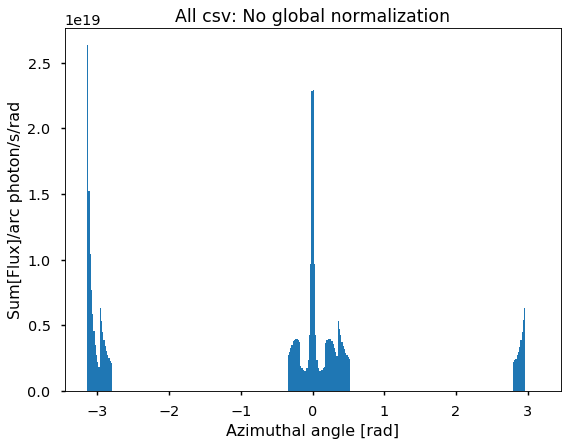

In [36]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame['Flux_[photon/s]'].to_numpy() / (2*np.pi/360) );
plt.title('All csv: No global normalization')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Sum[Flux]/arc photon/s/rad")

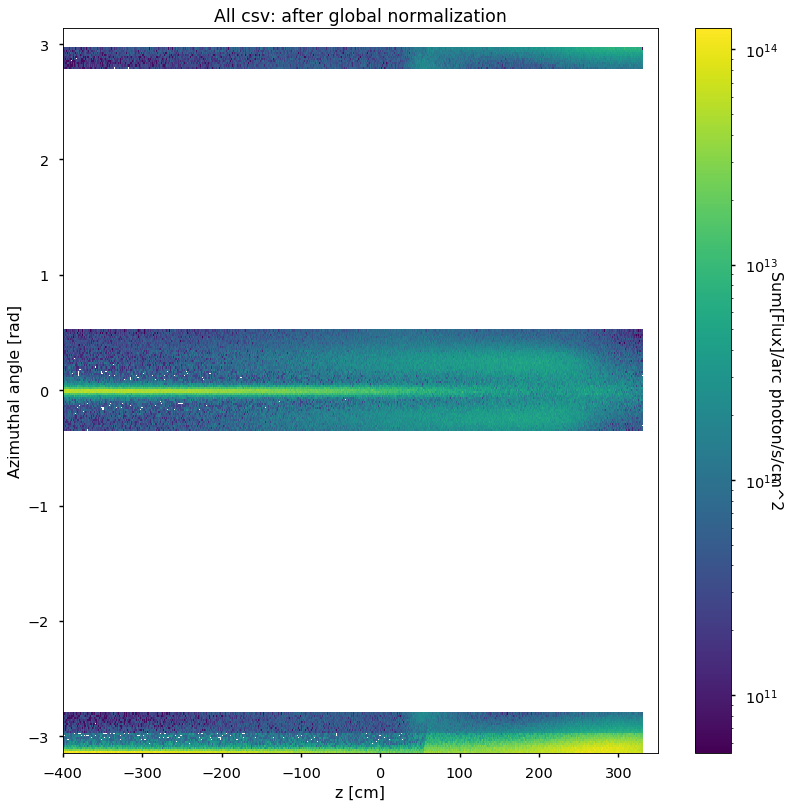

In [37]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
h = plt.hist2d(
    x = big_frame['Pos_Z_[cm]'],
    y = Phi.to_numpy(), 
    bins=[np.linspace(-400,350,num=750+1), np.linspace(-np.pi,np.pi,num=361) ] ,
    weights=big_frame['Flux_Normalized'].to_numpy() / (2*np.pi*2.9/360),
    norm=mpl.colors.LogNorm());
plt.title('All csv: after global normalization');
plt.xlabel("z [cm]");
plt.ylabel("Azimuthal angle [rad]");
cbar = plt.colorbar(h[3])
cbar.set_label('Sum[Flux]/arc photon/s/cm^2', rotation=270)


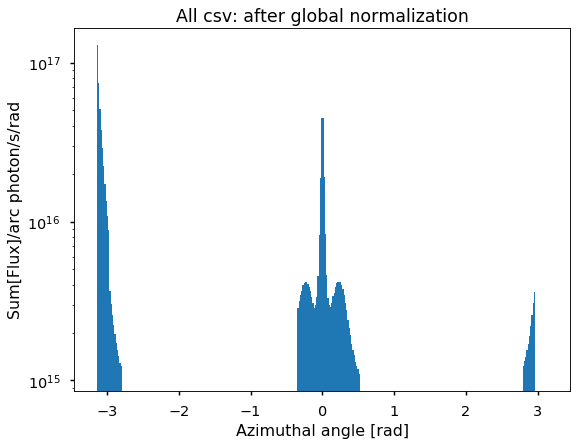

In [38]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame['Flux_Normalized'].to_numpy() / (2*np.pi/360),
    log = True );
plt.title('All csv: after global normalization');
plt.xlabel("Azimuthal angle [rad]");
plt.ylabel("Sum[Flux]/arc photon/s/rad");

Text(0, 0.5, 'Sum[Flux]/arc photon/s/rad')

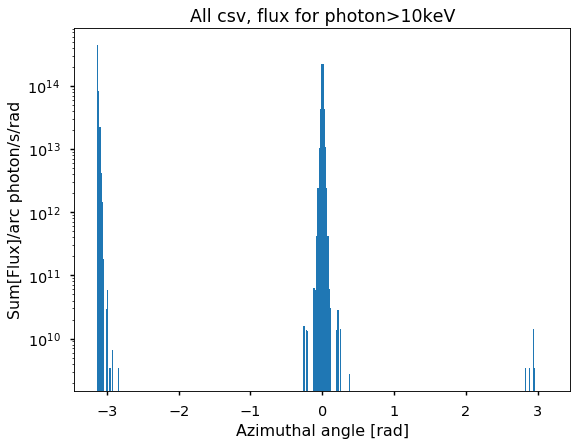

In [39]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3) * x['Flux_Normalized'], axis=1).to_numpy(),
    log = True);
plt.title('All csv, flux for photon>10keV')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Sum[Flux]/arc photon/s/rad")

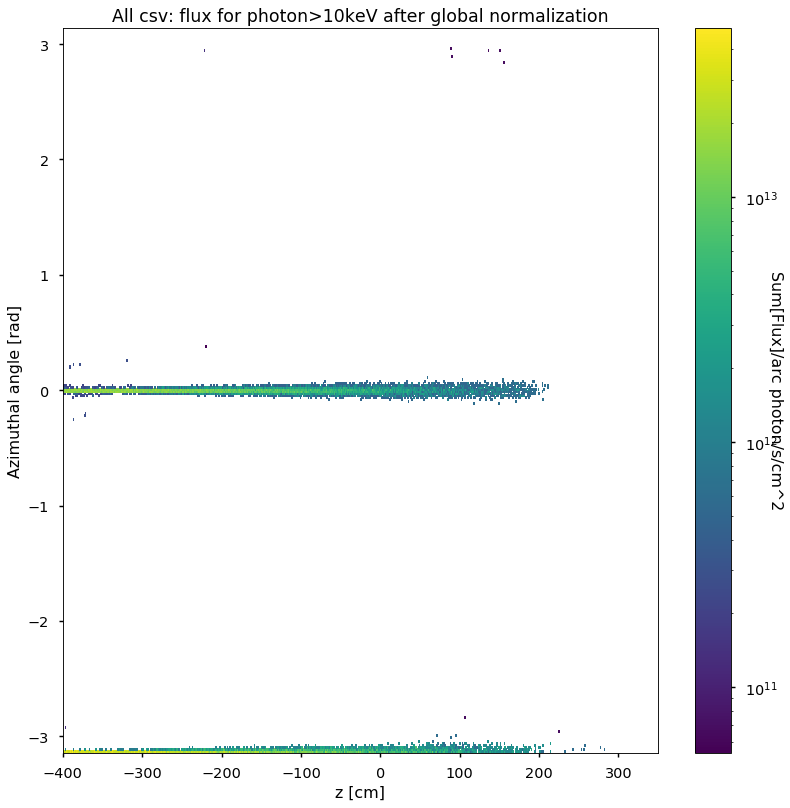

In [40]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
h = plt.hist2d(
    x = big_frame['Pos_Z_[cm]'],
    y = Phi.to_numpy(), 
    bins=[np.linspace(-400,350,num=750+1), np.linspace(-np.pi,np.pi,num=361) ] ,
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3) * x['Flux_Normalized'], axis=1).to_numpy() / (2*np.pi*2.9/360),
    norm=mpl.colors.LogNorm());
plt.title('All csv: flux for photon>10keV after global normalization');
plt.xlabel("z [cm]");
plt.ylabel("Azimuthal angle [rad]");
cbar = plt.colorbar(h[3])
cbar.set_label('Sum[Flux]/arc photon/s/cm^2', rotation=270)

Text(0, 0.5, 'Sum[Flux] photon/s/cm')

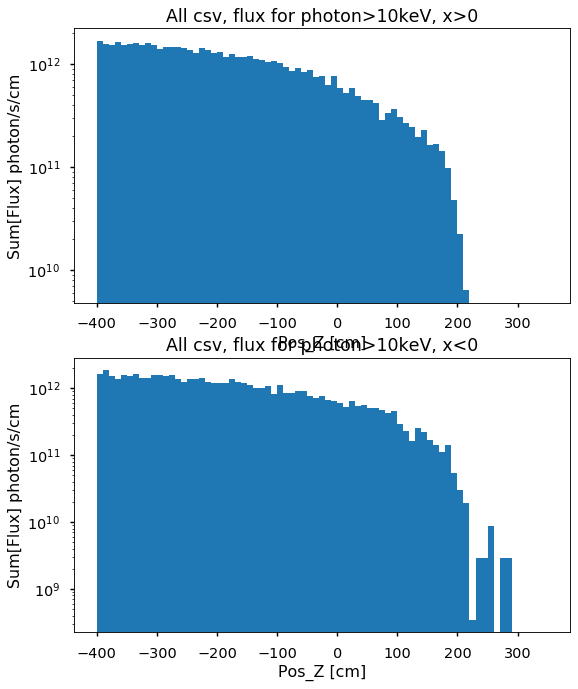

In [41]:
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2, 1, 1)
plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']>0) * x['Flux_Normalized'] / 10, axis=1).to_numpy(),
    log = True);
plt.title('All csv, flux for photon>10keV, x>0')
plt.xlabel("Pos_Z [cm]")
plt.ylabel("Sum[Flux] photon/s/cm")

plt.subplot(2, 1, 2)
plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']<0) * x['Flux_Normalized'] / 10, axis=1).to_numpy(),
    log = True);
plt.title('All csv, flux for photon>10keV, x<0')
plt.xlabel("Pos_Z [cm]")
plt.ylabel("Sum[Flux] photon/s/cm")

Text(0, 0.5, 'Sum[Flux] photon/s/cm')

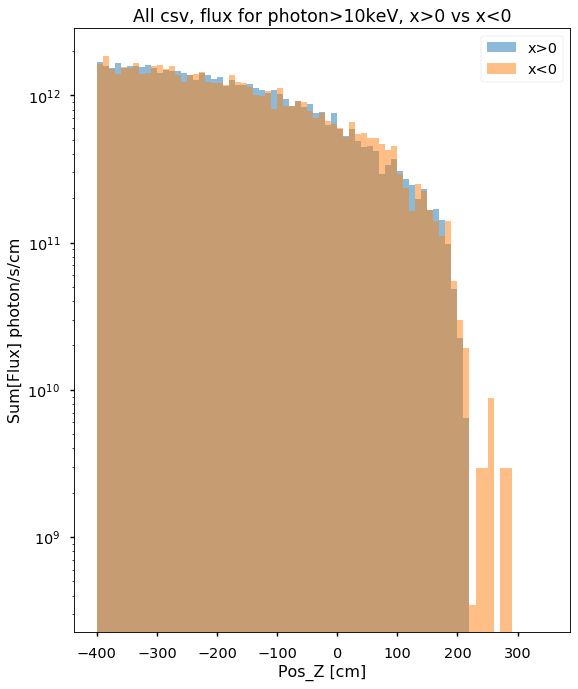

In [42]:
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')

plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']>0) * x['Flux_Normalized'] / 10, axis=1).to_numpy(),
    log = True, label='x>0', alpha = 0.5, lw=3);
plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']<0) * x['Flux_Normalized'] / 10, axis=1).to_numpy(),
    log = True, label='x<0', alpha = 0.5, lw=3);
plt.legend()

plt.title('All csv, flux for photon>10keV, x>0 vs x<0')
plt.xlabel("Pos_Z [cm]")
plt.ylabel("Sum[Flux] photon/s/cm")

Text(0, 0.5, 'Sum[Flux] virtual photon/cm')

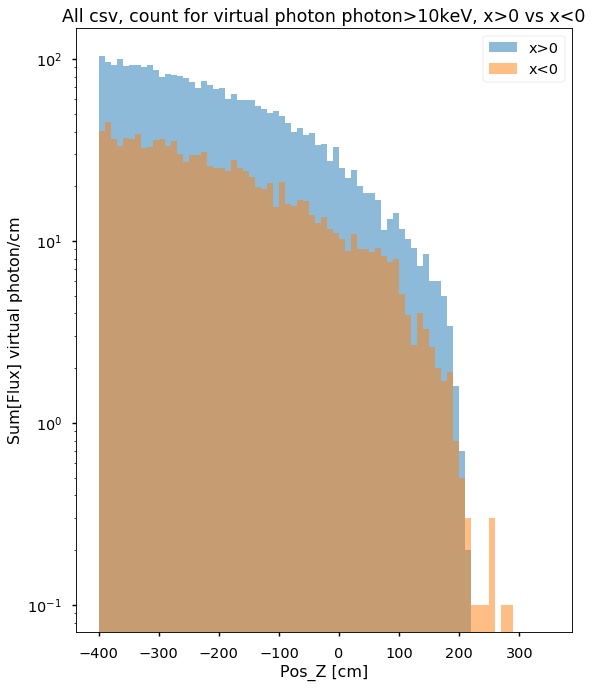

In [43]:
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')

plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']>0)  / 10, axis=1).to_numpy(),
    log = True, label='x>0', alpha = 0.5, lw=3);
plt.hist(
    big_frame['Pos_Z_[cm]'].to_numpy(), 
    bins=np.linspace(-400,350,num=75+1),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3 and x['Pos_X_[cm]']<0)  / 10, axis=1).to_numpy(),
    log = True, label='x<0', alpha = 0.5, lw=3);
plt.legend()

plt.title('All csv, count for virtual photon photon>10keV, x>0 vs x<0')
plt.xlabel("Pos_Z [cm]")
plt.ylabel("Sum[Flux] virtual photon/cm")

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3), axis=1).to_numpy(),
    log = True);
plt.title('All csv, count for virtual photon>10keV')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Virtual photon count per bin")

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(
    Phi.to_numpy(), 
    bins=np.linspace(-np.pi,np.pi,num=361),
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>2e3), axis=1).to_numpy(),
    log = True);
plt.title('All csv, count for virtual photon>2keV')
plt.xlabel("Azimuthal angle [rad]")
plt.ylabel("Virtual photon count per bin")

In [ ]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
h = plt.hist2d(
    x = big_frame['Pos_Z_[cm]'],
    y = Phi.to_numpy(), 
    bins=[np.linspace(-400,350,num=750+1), np.linspace(-np.pi,np.pi,num=361) ] ,
    weights=big_frame.apply(lambda x: int(x['Energy_[eV]']>2e3) * x['Flux_Normalized'], axis=1).to_numpy() / (2*np.pi*2.9/360),
    norm=mpl.colors.LogNorm());
plt.title('All csv: flux for photon>2keV after global normalization');
plt.xlabel("z [cm]");
plt.ylabel("Azimuthal angle [rad]");
cbar = plt.colorbar(h[3])
cbar.set_label('Sum[Flux]/arc photon/s/cm^2', rotation=270)


In [ ]:
big_frame.apply(lambda x: int(x['Energy_[eV]']>10e3), axis=1).sum()

In [ ]:
big_frame.apply(lambda x: int(x['Energy_[eV]']>2e3), axis=1).sum()

In [ ]:
# os.system('jupyter nbconvert --to html CheckAll.ipynb')
# os.system(f'mv CheckAll.html {base_dir}/')

In [ ]:
# from time import sleep
# from IPython.display import display, Javascript
# import hashlib

# def save_notebook(file_path):
#     start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
#     display(Javascript('IPython.notebook.save_checkpoint();'))
#     current_md5 = start_md5

#     while start_md5 == current_md5:
#         sleep(1)
#         current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
        
#     print(f'saved to {file_path} {start_md5} -> {current_md5}');


# save_notebook('CheckAll.ipynb')
os.system('jupyter nbconvert --to html CheckAll.ipynb')
print(os.popen(f'mv -fv CheckAll.html {base_dir}/').read())
